# Financial Sentiment Classification – Project Demo

This notebook provides a high-level overview of our sentiment analysis research project, focused on classifying financial text into **positive**, **neutral**, or **negative** sentiment.

We explore both traditional and modern approaches — from **Logistic Regression** to **FinBERT** and **GPT-4o** — and evaluate each model across diverse financial datasets.

The experiments and detailed code for each model are located in separate notebooks in the `notebooks/` folder.


## 1. Datasets Used

We use four key datasets covering various forms of financial text:

| Dataset      | Description                                                             |
| ------------ | ----------------------------------------------------------------------- |
| Twitter News | Financial tweets labeled as positive/neutral/negative                   |
| FiQA-2018    | Financial text dataset for sentiment and QA.                            |
| PhraseBank   | Expert-labeled financial news sentences labeled for sentiment analysis. |

> Note: FinBERT was trained on PhraseBank, so we exclude it from FinBERT evaluation to avoid data leakage.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("./data/processed/val.csv")
df.head()

,sentence,label,source
0,Technopolis and the St Petersburg government s...,positive,FPB
1,Cleveland Fed President Loretta Mester said th...,neutral,Twitter
2,Dow Chemically Speaking,neutral,Twitter
3,Pearl Harbor vets interment to be last on sunk...,neutral,Twitter
4,Stock Market Update Futures point to lower ope...,negative,Twitter


## 2. Label Distribution

We check the balance of sentiment labels in the validation set.


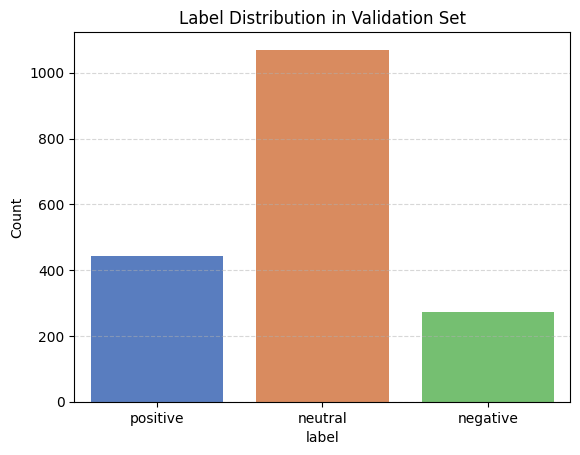

In [ ]:
sns.countplot(
    data=df,
    x="label",
    order=["positive", "neutral", "negative"],
    hue="label",
    palette="muted",
    legend=False,
)
plt.title("Label Distribution in Validation Set")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## 3. Dataset Composition

Each sample comes from one of three sources: Twitter, PhraseBank (FPB), or FiQA.

Below is the source distribution of the validation set.


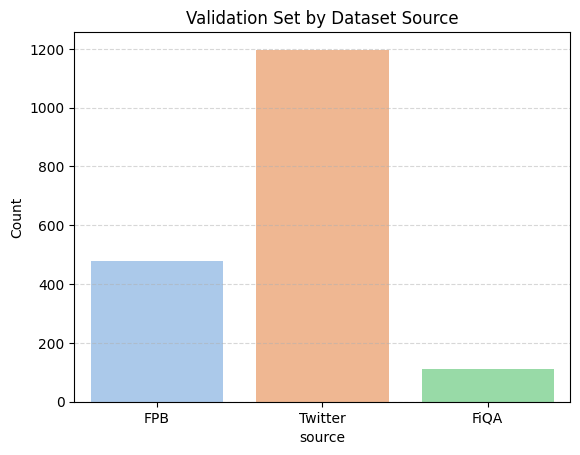

In [ ]:
sns.countplot(data=df, x="source", hue="source", legend=False, palette="pastel")
plt.title("Validation Set by Dataset Source")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## 4. Modeling Approaches

We test four approaches to sentiment classification:

| Model               | Type           | Notes                                      |
| ------------------- | -------------- | ------------------------------------------ |
| Logistic Regression | Traditional ML | TF-IDF + LogisticRegression                |
| FinBERT             | Transformer    | Pretrained on financial language (FinBERT) |
| SpaCy + TextBlob    | Rule-based NLP | Uses polarity from TextBlob                |
| GPT-4o (Azure)      | LLM            | Zero-shot, no domain finetuning            |

> Each model has its own notebook in `notebooks/`, including code, training/inference, and evaluation.


## 5. Overall Performance (Macro F1)

The chart below compares macro F1 scores (averaged across all classes) for each model.


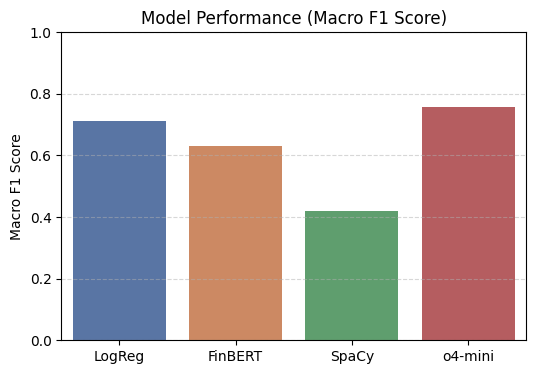

In [23]:
lr = pd.read_csv("./models/lr/lr-preds.csv", index_col=0)
finbert = pd.read_csv("./models/finbert/finbert-preds.csv", index_col=0)
spacy = pd.read_csv("./models/spacy/spacytextblob-preds.csv", index_col=0)
o4 = pd.read_csv("./models/o4/o4-mini-preds.csv", index_col=0)

f1_scores = {
    "LogReg": lr.loc["macro avg", "f1-score"],
    "FinBERT": finbert.loc["macro avg", "f1-score"],
    "SpaCy": spacy.loc["macro avg", "f1-score"],
    "o4-mini": o4.loc["macro avg", "f1-score"],
}

plt.figure(figsize=(6, 4))
sns.barplot(
    x=list(f1_scores.keys()),
    y=list(f1_scores.values()),
    hue=list(f1_scores.keys()),
    palette="deep",
    legend=False,
)
plt.ylim(0, 1)
plt.ylabel("Macro F1 Score")
plt.title("Model Performance (Macro F1 Score)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## 6. Confusion Matrix Samples

For full confusion matrix visualizations, refer to:

-   `2_logistic_regression_baseline.ipynb`
-   `3_finbert_inference.ipynb`
-   `4_spacy_textblob.ipynb`
-   `5_o4mini_inference.ipynb`

Each notebook includes model-specific plots and per-source evaluations.


## 7. Summary

-   o4-mini performs best overall, especially on the Twitter dataset.
-   FinBERT performs well on the Twitter and FiQA datasets.
-   Logistic Regression is surprisingly strong, fast, interpretable, and competitive.
-   Rule-based sentiment (SpaCy + TextBlob) lacks nuance in finance and performs poorly.

This demo serves as an entry point into the codebase. Use the links below to explore deeper:

-   [Data Preprocessing](./notebooks/1_data_preprocessing.ipynb)
-   [Logistic Regression](./notebooks/2_logistic_regression_baseline.ipynb)
-   [FinBERT](./notebooks/3_finbert_inference.ipynb)
-   [SpaCy](./notebooks/4_spacy_textblob.ipynb)
-   [GPT-4o](./notebooks/5_o4mini_inference.ipynb)
